In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
RANDOM_SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

<AxesSubplot: >

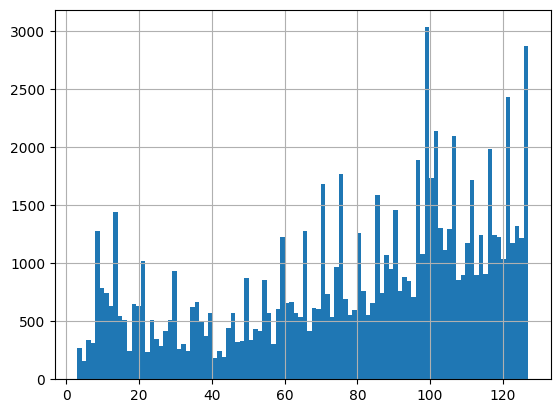

In [3]:
df = pd.read_csv("archive/2018-06-06-ss.cleaned.csv")

df = df[df["seq"].str.contains("[*]") == False]
maxlen_seq = 128

df = df.loc[df["seq"].str.len() < maxlen_seq]

df.len.hist(bins=100)

In [4]:
def n_grams(seqs, n=3):    
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs], object)
    #return [[sequence[i:i+n] for i in range(len(sequence))] for sequence in sequences]
    #n_grams = ngrams(nltk.word_tokenize(data), num)
    #return list(ngrams([char for char in seq], n=n) for seq in seqs)

In [5]:
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T

In [6]:
print(input_seqs[0], target_seqs[0])



len(input_seqs)%3

EDL CEC


0

In [7]:
x = n_grams(input_seqs)

In [8]:
np.array(x).shape


(87213,)

In [9]:
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(x)
input_data = tokenizer_encoder.texts_to_sequences(x)
input_data = pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((87213, 128), (87213, 128, 4))

In [10]:
reverse_decoder_index = {value: key for key, value in tokenizer_decoder.word_index.items()}
reverse_decoder_index

{1: 'c', 2: 'h', 3: 'e'}

In [11]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

8421 4


In [12]:
class LSTM(nn.Module):
    def __init__(self, n_words, maxlen_seq, n_tags, hidden_size=64, dropout=0.1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(n_words, 128, padding_idx=0)
        self.bilstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=1, 
                              batch_first=True, bidirectional=True, dropout=dropout)
        self.dense = nn.Linear(hidden_size*2, n_tags)
        
    def forward(self, x):
        return self.dense(self.bilstm(self.embedding(x))[0])

In [13]:
model = LSTM(n_words, maxlen_seq, n_tags)

C:\Users\Leagr\miniconda3\envs\mol3022\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
def q3_acc(y_true, y_pred):
    y = torch.argmax(y_true, dim=-1)
    y_ = torch.argmax(y_pred, dim=-1)
    mask = (y > 0)
    return torch.mean((y[mask] == y_[mask]).float())

In [15]:
optimizer = torch.optim.RMSprop(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)

In [17]:
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

In [18]:
for epoch in range(5):
    running_loss = 0.0
    model.train()
    for i in tqdm(range(0, len(X_train), 128)):
        inputs = torch.tensor(X_train[i:i+128]).to(device)
        targets = torch.tensor(y_train[i:i+128]).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs.view(-1, n_tags), targets.view(-1, n_tags))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate the model on the validation data
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test).to(device))
        val_loss = loss_fn(y_pred.view(-1, n_tags), torch.tensor(y_test).view(-1, n_tags)).item()
        val_acc = q3_acc(torch.tensor(y_test).to(device), y_pred)

    print('Epoch: %d | Train loss: %.4f | Val loss: %.4f | Val acc: %.4f' %
          (epoch+1, running_loss / (len(X_train) // 128), val_loss, val_acc))

  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.3257 | Val loss: 0.2566 | Val acc: 0.8431


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 0.2125 | Val loss: 0.2313 | Val acc: 0.8622


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 3 | Train loss: 0.1830 | Val loss: 0.2188 | Val acc: 0.8722


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 4 | Train loss: 0.1681 | Val loss: 0.2039 | Val acc: 0.8808


  0%|          | 0/409 [00:00<?, ?it/s]

Epoch: 5 | Train loss: 0.1633 | Val loss: 0.2028 | Val acc: 0.8838


In [19]:
#model.load_state_dict(torch.load('model_1.torch', map_location=torch.device('cpu')))

training
---
Input: TQEAFDLISKENPSSQYWKEVAEQRRKALYEALKENEKLHKEIEQKDSEIARLRKENKDLAEVAEHVQYMAEVIERLSN
Target: CCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHCCCC
Result: CCCHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCC


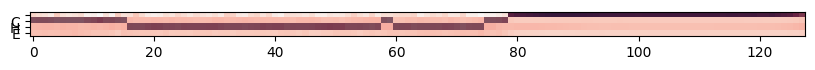

---
Input: GGTIAKVTGPSTGAVGRNIEFSGKDSKDEDGKIVSYDWDFGDGATSRGKNSVHAYKKAGTYNVTLKVTDDKGATATESFTIEIKN
Target: CCCECCCEEECEEECCCEEEEECCCCECCCCCEEEEEEECCCCCEEECCEEEEECCCCEEEEEEEEEEECCCCEEEEEEEEEEEC
Result: CCCECCCEEECEEEEECEEEEEECCCCCCCCCEEEEEEECCCCCEEECCEEEEECCCCEEEEEEEEEEECCCCEEEEEEEEEEEC


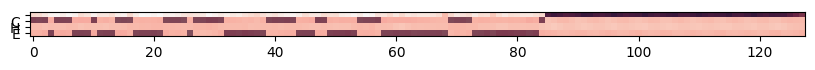

---
Input: MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Target: CCCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC
Result: CCCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC


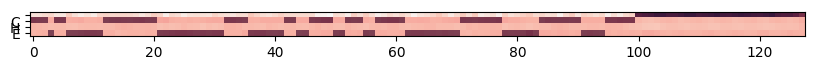

testing
---
Input: MEFQKKKQKVIQVKEIKFRPGTDEGDYQVKLRSLIRFLEEGDKAKITLRFRGREMAHQQIGMEVLNRVKDDLQELAVVESFPTKIEGRQMIMVLAPKKKQ
Target: CCCCCCCCCCCEEEEEEECCCCCHHHHCHHHHHHHHHHHCCEEEEEEECCCCCCCCCCCHHHHHHHHHHHHHCCCEEECCCCCCCCCCCCEEEEEECCCC
Result: CCCCCCCCEEEEEEEEEECCCCCCCCEHEEECCEEEEEECCCCEEEEEEECHHHHHHHHCHHHHHHHHHHHHHHCCCCCCCCCCCCEECECEEECCCCCC


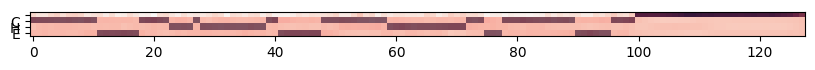

---
Input: STNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTE
Target: CCCCCCCCCCCCCCCCCCCHHHHHHHHCHHHHHHCCCCCHHHCCCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCCCCCCCCCCCCCCHHHHHHHHCHHHHHHCCCCCHHHCCCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHCCCCCC


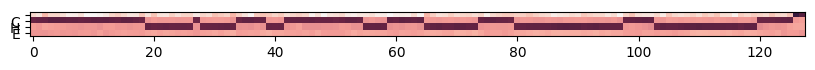

---
Input: SMSVKKPKRDDSKDLALCSMILTEMETHEDAWPFLLPVNLKLVPGYKKVIKKPMDFSTIREKLSSGQYPNLETFALDVRLVFDNCETFNEDDSDIGRAGHNMRKYFEKKWTDTFK
Target: CCCCCCCCCCCCCHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCCCCCHHHHHHHHHHHHHHCHHHHHHCCCCCCCCCCCHHHHCCCCCCHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHC


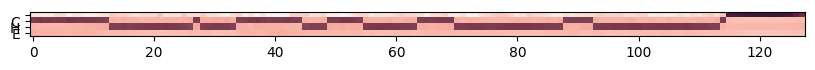

In [20]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model(torch.tensor(X_train[:N])).detach().numpy()
y_test_pred = model(torch.tensor(X_test[:N])).detach().numpy()
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

In [21]:
torch.save(model.state_dict(), "model_1.torch")